Source:

huggingface: https://huggingface.co/HooshvareLab/bert-fa-base-uncased-clf-persiannews

Tutorial:https://towardsdatascience.com/fine-tuning-hugging-face-model-with-custom-dataset-82b8092f5333

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
os.chdir('/content/drive/MyDrive/sharif/FineTuning/ipython(guide)')

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.8MB 6.4MB/s 
     |████████████████████████████████| 2.9MB 37.6MB/s 
     |████████████████████████████████| 890kB 46.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=f8f58b54d6e6315614747ecabcf62985991aa4515be8abe382949eddab562000
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
!pip3 install sentencepiece

     |████████████████████████████████| 1.2MB 4.8MB/s 


In [ ]:
!git clone https://huggingface.co/HooshvareLab/bert-fa-base-uncased-clf-persiannews
GIT_LFS_SKIP_SMUDGE=1

fatal: destination path 'bert-fa-base-uncased-clf-persiannews' already exists and is not an empty directory.


In [ ]:
!pip install -q clean-text[gpl]

     |████████████████████████████████| 71kB 4.3MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 245kB 20.1MB/s 


In [ ]:
!pip install -q hazm

     |████████████████████████████████| 317kB 5.2MB/s 
     |████████████████████████████████| 235kB 16.1MB/s 
     |████████████████████████████████| 1.4MB 17.5MB/s 


In [ ]:
import torch
import numpy
import pandas
import re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification,AutoConfig,TFAutoModel,AutoModel
from transformers import BertConfig, BertTokenizer
from transformers import TFBertModel, TFBertForSequenceClassification
from transformers import glue_convert_examples_to_features, InputExample
from sklearn.metrics import classification_report

import hazm
from cleantext import clean


In [ ]:
# specify GPU
device = torch.device("cuda")

## Data

In [ ]:
# data = pandas.read_csv('../Data/ParsBert.csv')
# data = data.dropna().reset_index(drop=True)
# X = data["body"].values.tolist()
# y = pandas.read_csv('../Data/ParsBert.csv')
# labels = []
# tag=[]
# for item in y['tag']:
#   labels += [i for i in re.sub('\"|\[|\]|\'| |=','',item.lower()).split(",") if i!='' and i!=' ']
#   tag.append([i for i in re.sub('\"|\[|\]|\'| |=','',item.lower()).split(",") if i!='' and i!=' '])
# labels = list(set(labels))
# mlb = MultiLabelBinarizer()
# Y=mlb.fit_transform(tag)

In [ ]:
# #All data befor pre-processing...
data = pandas.read_csv('/content/drive/MyDrive/sharif/Spider/Data/unpreprocessed_dataset.csv')
# print(data['body'])
# print(data.shape)
X = data["body"].values.tolist()
# y = pandas.read_csv('../Data/limited_to_'+str(limit_number)+'.csv')
y=data["tag"].values.tolist()
labels = []
tag=[]
for item in y:
  labels += [i for i in re.sub('\"|\[|\]|\'| |=','',item.lower()).split(",") if i!='' and i!=' ']
  tag.append([i for i in re.sub('\"|\[|\]|\'| |=','',item.lower()).split(",") if i!='' and i!=' '])
labels = list(set(labels))
mlb = MultiLabelBinarizer()
Y=mlb.fit_transform(tag)

In [ ]:
# for i in range(10):
#   print(X[i])
#   print(Y[i])

In [ ]:
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext


def cleaning(text):
    text = text.strip()
    
    # regular cleaning
    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
    )

    # cleaning htmls
    text = cleanhtml(text)
    
    # normalizing
    normalizer = hazm.Normalizer()
    text = normalizer.normalize(text)
    
    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    
    text = wierd_pattern.sub(r'', text)
    
    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)
    
    return text

In [ ]:
# cleaning taxt
clean_x=[]
for t in X:
  clean_x.append(cleaning(t))


In [ ]:
for i in range(10):
  print(clean_x[i])

اگر جزو آن دسته دولوپرهایی هستید که پس از چندین و چند سال کدنویسی و کسب تجربه کماکان از عملکرد خود راضی نیستید، توصیه می‌‌کنیم به ارزیابی دقیق‌تر کار خود بپردازید. به عبارت دیگر، ببینید که آیا حرفه‌‌ای عمل می‌‌کنید؟ آیا از نسبت میان میزان proficiency و competency خود اطلاع دارید؟ آیا می‌‌دانید چه راه‌کارهایی را برای افزایش بهره‌‌وری خود می‌بایست در پیش بگیرید؟ واقعیت امر آن است که در اغلب موارد، دو مفهوم proficiency و competency مشابه یکدیگر در نظر گرفته می‌شوند؛ اما در حقیقت این‌طور نیست! چنانچه این دو واژه واقعا هم‌معنا بودند، هر کسی که در هر کاری سررشته داشت می‌بایست در کار خود بهترین می‌بود؛ به‌ علاوه اینکه شکی نیست که در قرن بیست و یکم، هر روز بیش از روز قبل نیاز به کسب تخصص احساس می‌شود. با‌توجه به میزان و شتاب گسترش اطلاعات از یک سو و همچنین رقابت شدید متخصصان برای ربودن گوی سبقت از رقبای خود از سوی دیگر، قطعا کسب proficiency برای فعالان حوزهٔ کسب‌وکار یک ضرورت است. به‌ طور کلی، آنچه در ادامه قصد داریم مورد بررسی قرار دهیم این است که به چه شکل می‌توان با تلفیق proficiency و comp

In [ ]:
# limit_number = 750
# data = pandas.read_csv('../Data/limited_to_'+str(limit_number)+'.csv',index_col=0)
# data = data.dropna().reset_index(drop=True)
# X = data["body"].values.tolist()
# y = pandas.read_csv('../Data/limited_to_'+str(limit_number)+'.csv')
# labels = []
# tag=[]
# for item in y['tag']:
#   labels += [i for i in re.sub('\"|\[|\]|\'| |=','',item.lower()).split(",") if i!='' and i!=' ']
#   tag.append([i for i in re.sub('\"|\[|\]|\'| |=','',item.lower()).split(",") if i!='' and i!=' '])
# labels = list(set(labels))
# mlb = MultiLabelBinarizer()
# Y=mlb.fit_transform(tag)

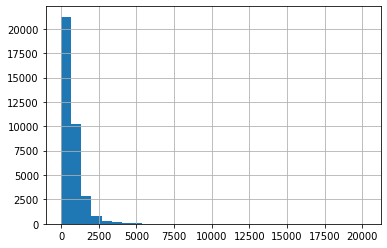

In [ ]:
seq_len = [len(i.split()) for i in clean_x]
pandas.Series(seq_len).hist(bins = 30)

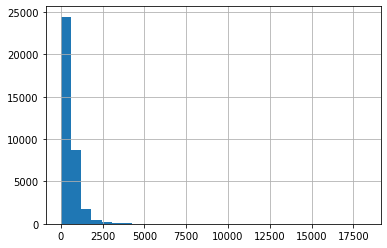

In [ ]:
seq_len = [len([j for j in i.split() if len(j)>2]) for i in X]
pandas.Series(seq_len).hist(bins = 30)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(clean_x,Y , test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)
print('train: ', len(X_train) , '\ntest: ', len(X_test) , '\nval: ', len(X_val) ,"\ny_tain:",len(y_train) )

train:  21399 
test:  7134 
val:  7134 
y_tain: 21399


In [ ]:
##we would load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased-clf-persiannews")

In [ ]:
#example
text = "ما در هوشواره معتقدیم با انتقال صحیح دانش و آگاهی، همه افراد میتوانند از ابزارهای هوشمند استفاده کنند. شعار ما هوش مصنوعی برای همه است."
tokenized=tokenizer.tokenize(X_train[0])
input_ids = tokenizer.convert_tokens_to_ids(tokenized)
print(tokenized)
print(input_ids)


['عصری', 'زندگی', 'می', '\\', 'xa', '##d', '##کنیم', 'کره', 'زمین', 'دهک', '##د', 'جهانی', 'فراهم', 'توانایی', 'هر', '\\', 'xa', '##d', '##جایی', 'کره', 'خاکی', 'عرضه', 'توانایی', 'بهره', '\\', 'xa', '##d', '##برداری', 'ارتباطی', 'منطقه', 'جغرافیایی', 'اصطلاحا', 'کار', 'می', '\\', 'xa', '##d', '##کنند', 'فریلنسر', 'ازادکار', 'می', '\\', 'xa', '##d', '##شود', 'دنبال', 'ازادی', 'زندگی', 'حرفه', '\\', 'xa', '##d', 'داشتهباشید', 'بتوانید', 'متناسب', 'سلایق', 'کار', 'درامد', 'کسب', 'فریلنس', 'ازادکار', '##ی', 'تجربه', 'ای', 'ناب', 'خواهدبود', 'فریلنسر', 'شاخصه', '\\', 'xa', '##d', 'ها', 'تقویت', 'عده', 'ی', 'کثیری', 'فریلنسر', 'می', '\\', 'xa', '##d', 'نامند', 'مشکل', 'اساسی', 'انتصاب', '\\', 'xa', '##d', '##هم', 'توانایی', 'برد', 'جذب', 'پروژه', '\\', 'xa', '##d', 'ها', 'اساس', 'مهارت', 'هایشان', 'ازادکار', 'ازاد', 'کار', 'موضوعی', 'قصد', 'مقاله', 'صحبت', 'ازادکار', 'کار', 'در', '\\', 'xa', '##d', '##ا', '\\', 'xa', '##d', '##مد', 'کسب', 'مقاله', 'نیازمندی', '\\', 'xa', '##d', 'ها', 'فریلن

In [ ]:
# encode text
sent_id = tokenizer.batch_encode_plus(X_train[:10], padding=True, return_token_type_ids=False)

In [ ]:
sent_id

{'input_ids': [[2, 5071, 4790, 32701, 3911, 19910, 74701, 3329, 52810, 2030, 4613, 57968, 7341, 4957, 3916, 3911, 4613, 9607, 39230, 4378, 28724, 36539, 5929, 15619, 20936, 41215, 2002, 5102, 57637, 6012, 74701, 5565, 2867, 5929, 26040, 6501, 4484, 64198, 5438, 13334, 23344, 58164, 6012, 6820, 58164, 4766, 6667, 33103, 35204, 6921, 37745, 23460, 4366, 5929, 2959, 45309, 8146, 4856, 4613, 2938, 5782, 4394, 2959, 45098, 60379, 2061, 45309, 8146, 29511, 5929, 52446, 11231, 2867, 6921, 8094, 52810, 64831, 35138, 33103, 62321, 4366, 5929, 2959, 27409, 45309, 8146, 23460, 4613, 35667, 33103, 62321, 6921, 37745, 4366, 5929, 33336, 2959, 27409, 45309, 8146, 52810, 64831, 35138, 4484, 18009, 92228, 74701, 37458, 48687, 52446, 22157, 45498, 29420, 4090, 23709, 2050, 30750, 7796, 6945, 11999, 32701, 3528, 10672, 35428, 17389, 5655, 3030, 5071, 3329, 52810, 2030, 4613, 44594, 18230, 4790, 52248, 7120, 28678, 10741, 3531, 3916, 45309, 62071, 88012, 5929, 74701, 3462, 5289, 7222, 5071, 96817, 88012,

In [ ]:
sentence_maxlen=128

In [ ]:
##Tokenize training and validation sentences:
train_encodings = tokenizer.batch_encode_plus(X_train,
    max_length = sentence_maxlen,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
    )

val_encodings = tokenizer.batch_encode_plus(X_val,
    max_length = sentence_maxlen,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
    )

test_encodings=tokenizer.batch_encode_plus(X_test,
    max_length = sentence_maxlen,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
    )

In [ ]:
train_encodings[0]

Encoding(num_tokens=128, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [ ]:
import torch
import torch.nn as nn

# for train set
train_seq = torch.tensor(train_encodings['input_ids'])
train_mask = torch.tensor(train_encodings['attention_mask'])
train_y = torch.FloatTensor(y_train)

# for validation set
val_seq = torch.tensor(val_encodings['input_ids'])
val_mask = torch.tensor(val_encodings['attention_mask'])
val_y = torch.FloatTensor(y_val)

# for test set
test_seq = torch.tensor(test_encodings['input_ids'])
test_mask = torch.tensor(test_encodings['attention_mask'])
test_y = torch.FloatTensor(y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone()

In [ ]:
train_y[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for validation set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

In [ ]:
# example


text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)
print(sent_id)

seq = torch.tensor(sent_id['input_ids'])
mask = torch.tensor(sent_id['attention_mask'])
train_y = torch.tensor([0,1])

transformer_model = AutoModel.from_pretrained("HooshvareLab/bert-fa-base-uncased-clf-persiannews")
cls_hs=transformer_model(seq,mask)
print(cls_hs)
print(cls_hs[0])
print(cls_hs[1])
print(cls_hs[1].shape)
print(cls_hs[0].shape)

{'input_ids': [[2, 32071, 9574, 1026, 89390, 36260, 84378, 40908, 2041, 4, 0], [2, 13632, 25909, 70608, 1011, 40716, 2033, 1026, 89390, 36260, 4]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}
BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.0526,  0.5571, -0.4614,  ..., -0.0968,  0.4727,  0.1742],
         [-0.2566,  1.5509, -2.0229,  ..., -1.1688, -0.4160,  0.1496],
         [-0.1851,  0.1336, -1.3189,  ..., -0.5912, -0.4864,  0.4295],
         ...,
         [-0.2249,  0.1459, -1.4157,  ..., -0.1764,  0.6163, -0.5646],
         [-0.3767, -0.2304, -0.3158,  ..., -0.5575,  0.0901,  0.6220],
         [-0.2883,  0.2287, -1.5781,  ..., -0.3559,  0.3813,  0.0665]],

        [[ 0.0939, -0.5881, -1.2552,  ...,  0.9090,  0.5908, -0.1969],
         [-0.2802, -0.9775, -1.5731,  ...,  0.0902,  0.5980, -0.6988],
         [-0.2920, -0.6260, -0.9620,  ..., -0.4935,  0.6855, -1.1112],
         ...,
         [-0.1571, -0.1198, -2

## Model

In [ ]:
transformer_model = AutoModel.from_pretrained("HooshvareLab/bert-fa-base-uncased-clf-persiannews")

In [ ]:
# freeze all the parameters
for param in transformer_model.parameters():
    param.requires_grad = False
    

In [ ]:
classnum=len(labels)
classnum

80

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2
      self.fc2 = nn.Linear(512,256)

      # dense layer 3
      self.fc3 = nn.Linear(256,128)
      
      
      # dense layer 4 (Output layer)
      self.fc4 = nn.Linear(128,classnum)

      #sigmoid activation function
      self.sigmoid = nn.Sigmoid()

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs[1])
      
      x = self.relu(x)

      x = self.dropout(x)

      x = self.fc2(x)
      
      x = self.relu(x)

      x = self.dropout(x)

      x = self.fc3(x)
      
      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc4(x)
      
      # apply sigmoid activation
      x = self.sigmoid(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(transformer_model)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW


# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=5e-3)

In [ ]:
##Calculating weights 
class_counts=[0]*classnum
for cl in Y:
    #  print(cl)
     for i in range(classnum):
      #  print(i)
       if cl[i]==1:
          class_counts[i]+=1
print(class_counts)

weight=[]
for indx in range(classnum):
  weight.append(((class_counts[indx]/len(Y))))

print(weight)

# class_weight= torch.tensor(weight,dtype=torch.float)
class_weight = torch.FloatTensor(weight)
class_weight = class_weight.to(device)
print(class_weight)

[580, 3730, 91, 1283, 88, 68, 80, 1408, 261, 222, 584, 1008, 34, 57, 84, 81, 1263, 518, 2839, 630, 311, 770, 721, 200, 735, 370, 1020, 949, 808, 1481, 783, 282, 481, 551, 1098, 509, 919, 1136, 69, 222, 160, 1176, 575, 405, 1040, 1167, 119, 174, 1339, 1481, 288, 155, 121, 286, 466, 763, 211, 282, 201, 3061, 939, 970, 307, 2391, 825, 690, 417, 1126, 144, 602, 3323, 2416, 559, 3518, 605, 200, 147, 959, 311, 615]
[0.01626153026607228, 0.1045784618835338, 0.002551378024504444, 0.03597162643339782, 0.0024672666610592426, 0.0019065242380912329, 0.0022429696918720384, 0.03947626657694788, 0.007317688619732526, 0.006224240894944907, 0.016373678750665883, 0.028261418117587686, 0.0009532621190456164, 0.0015981159054588275, 0.0023551181764656405, 0.002271006813020439, 0.035410884010429806, 0.01452322875487145, 0.07959738694030898, 0.017663386323492306, 0.00871954467715255, 0.02158858328426837, 0.02021476434799675, 0.005607424229680097, 0.020607284044074355, 0.010373734824908179, 0.0285978635713684

In [ ]:
# loss_func =nn.MultiLabelMarginLoss()
# loss_func=nn.BCEWithLogitsLoss(weight=class_weight)
loss_func=nn.BCELoss(weight=class_weight)
# loss_func=nn.NLLLoss(weight=class_weight)

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch
   
    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)
    
    # compute the loss between actual and predicted values
    loss=loss_func(preds,labels)
    
    # loss=0
      
    # for b in range(batch_size):
    #   for l in range(classnum):
    #     print(preds[b][l], labels[b][l])
    #     loss += loss_func(preds[b][l], labels[b][l])

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = numpy.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch
    

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)
      
      # compute the validation loss between actual and predicted values

      # loss=0
      # for b in range(batch_size):
      #   for l in range(classnum):
      #     loss += loss_func(preds[b][l], labels[b][l])
      
      loss=loss_func(preds,labels)
      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = numpy.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [ ]:
# number of training epochs
epochs = 10

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights_4fc.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    669.
  Batch   100  of    669.
  Batch   150  of    669.
  Batch   200  of    669.
  Batch   250  of    669.
  Batch   300  of    669.
  Batch   350  of    669.
  Batch   400  of    669.
  Batch   450  of    669.
  Batch   500  of    669.
  Batch   550  of    669.
  Batch   600  of    669.
  Batch   650  of    669.

Evaluating...
  Batch    50  of    223.
  Batch   100  of    223.
  Batch   150  of    223.
  Batch   200  of    223.

Training Loss: 0.015
Validation Loss: 0.015

 Epoch 2 / 10
  Batch    50  of    669.
  Batch   100  of    669.
  Batch   150  of    669.
  Batch   200  of    669.
  Batch   250  of    669.
  Batch   300  of    669.
  Batch   350  of    669.
  Batch   400  of    669.
  Batch   450  of    669.
  Batch   500  of    669.
  Batch   550  of    669.
  Batch   600  of    669.
  Batch   650  of    669.

Evaluating...
  Batch    50  of    223.
  Batch   100  of    223.
  Batch   150  of    223.
  Batch   200  of    223.

Training L

Loading saved model:

In [ ]:
# torch.cuda.empty_cache()
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(transformer_model)

# push the model to GPU
model = model.to(device)

In [ ]:
#load weights of best model
path = 'saved_weights_4fc.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

After loading model:

In [ ]:
y_pred=[]
y_true=[]
for step,batch in enumerate(test_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      # outputs_before_sigmoid = model(sent_id, mask)
      preds = model(sent_id, mask)
      # print(preds)
      # print(preds.cpu().numpy())
      
      
      # outputs_before_sigmoid = outputs_before_sigmoid.cpu().numpy()
      # model's performance
    # preds = numpy.argmax(preds, axis = 1)
    # print(len(preds),len(preds[0]))
    # measure = numpy.mean(preds[0]) + 1.15*numpy.sqrt(numpy.var(preds[0]))
    # print(measure)


    # preds=[]
    # for l in range(len(outputs_before_sigmoid)):
    #   preds.append(torch.sigmoid(outputs_before_sigmoid[l]))
    # preds = preds.cpu().numpy()
    # print(preds)
    # measure = numpy.mean(preds[0]) + 1.15*numpy.sqrt(numpy.var(preds[0]))
    # for l in range(len(outputs_before_sigmoid)):
    #   temp=[]
    #   for value in preds:
    #     if value >= measure:
    #       temp.append(1)
          
    #     else:
    #       temp.append(0)
    #   y_pred.append(temp)
    #   y_true.append(labels.cpu().numpy()[l])
    #   # print( preds[l])
    #   print("temp:",(temp))
    #   print("labels:",labels.cpu().numpy()[l])
    
    # print(labels.cpu().numpy()[0], preds[0])
  

    # for l in range(len(preds)):
    #   preds.append(torch.sigmoid(outputs_before_sigmoid[l]))
    # preds = preds.cpu().numpy()
    # print(preds)
    preds = preds.cpu().numpy()
    measure = numpy.mean(preds[0]) + 1.15*numpy.sqrt(numpy.var(preds[0]))
    for l in range(len(preds)):
      temp=[]
      for value in preds[l]:
        if value >= measure:
          temp.append(1)
          
        else:
          temp.append(0)
      y_pred.append(temp)
      y_true.append(labels.cpu().numpy()[l])
      # print( preds[l])
      # print("temp:",(temp))
      # print("labels:",labels.cpu().numpy()[l])

print(classification_report(y_true, y_pred))

  Batch    50  of    223.
  Batch   100  of    223.
  Batch   150  of    223.
  Batch   200  of    223.
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.00      0.00      0.00       740
           2       0.00      0.00      0.00        14
           3       0.03      0.89      0.06       239
           4       0.00      0.00      0.00        19
           5       0.00      0.15      0.00        13
           6       0.00      0.00      0.00        17
           7       0.00      0.00      0.00       293
           8       0.00      0.00      0.00        57
           9       0.00      0.00      0.00        41
          10       0.00      0.00      0.00       110
          11       0.00      0.00      0.00       190
          12       0.00      0.00      0.00         9
          13       0.00      1.00      0.00        14
          14       0.00      0.00      0.00        13
          15       0.00      0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
